In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import bluebonnet as bb
from bluebonnet.flow.reservoir import IdealReservoir, FlowProperties, SinglePhaseReservoir,RelPermParams
from bluebonnet.fluids.fluid import Fluid, pseudopressure

plt.style.use("ggplot")

In [ ]:
def plot_pseudopressure(reservoir, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(0, 1, reservoir.nx)
    for i, p in enumerate(reservoir.pseudopressure):
        if i % 200 == 0:
            ax.plot(x,p, color='steelblue')
    ax.set(xlabel="x", ylabel="Pseudopressure", xlim=(0, 1), ylim=(0,1.05))
    return fig, ax

def plot_recovery_factor(reservoir, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    time = reservoir.time
    ax.plot(time, rf)
    ax.set(xscale='squareroot', ylim=(0, None), xlim=(0, max(time)))
    tick_locs = np.round((np.linspace(0,1,7) * np.sqrt(max(time)))**2,1)
    ax.set_xticks(tick_locs)
    return ax

import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """
 
    name = 'squareroot'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax
 
    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return np.array(a)**0.5
 
        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()
 
    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return np.array(a)**2
 
        def inverted(self):
            return SquareRootScale.SquareRootTransform()
 
    def get_transform(self):
        return self.SquareRootTransform()
 
mscale.register_scale(SquareRootScale)

# Ideal gas simulation

In [3]:
t_end = 6
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2

res_ideal = IdealReservoir(50, 1000, 9000, None)
%time res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()

CPU times: user 4.86 s, sys: 3.34 ms, total: 4.86 s
Wall time: 4.86 s


[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Recovery factor')]

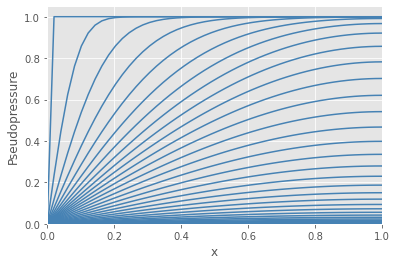

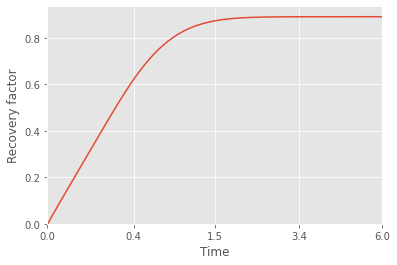

In [4]:
ax = plot_pseudopressure(res_ideal)

ax = plot_recovery_factor(res_ideal)
ax.set(xlabel="Time", ylabel="Recovery factor")

# Real gas simulation
(currently failing to capture FVF properly)

<AxesSubplot:xlabel='pseudopressure'>

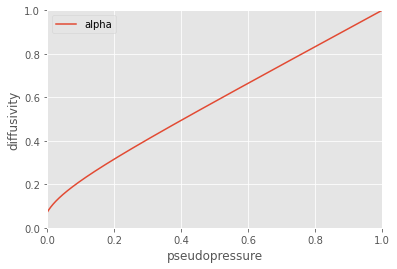

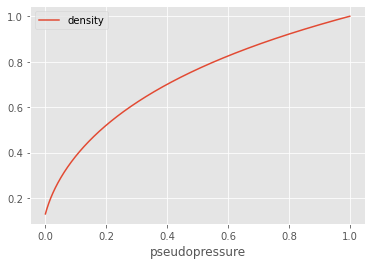

In [36]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")

def scale_pressure_diffusivity(df):
    out = df.assign(
        alpha=lambda x: 1/(x.Cg * x.Viscosity), 
        density=lambda x: x.Density/max(x.Density),
        pseudopressure=lambda x: (x["pseudopressure"] - x["pseudopressure"].min()) / 
            (x["pseudopressure"].max() - x["pseudopressure"].min()),
    ).assign(
        alpha=lambda x: x.alpha/x.alpha.iloc[-1]
    )[["pseudopressure", "alpha", "density"]]
    return out

fluid_properties = (
    pvt_gas[pvt_gas.P>=1000]
    .pipe(scale_pressure_diffusivity)
)
ax = fluid_properties.plot(x='pseudopressure', y="alpha")
ax.set(ylim=(0,1), xlim=(0,1), ylabel="diffusivity")
fluid_properties.plot(x="pseudopressure", y="density")

# When things have gone wrong

In [7]:
%%time
pressure_fracface = 1000
reservoirs = {}
for pressure_res in np.arange(5e3,12e3,1e3):
    fluid_properties = (
        pvt_gas[pvt_gas.P>=pressure_fracface][lambda x: x.P <= pressure_res]
        .pipe(scale_pressure_diffusivity)
    )
    flow_properties = FlowProperties(fluid_properties, fvf_scale=1)
    reservoirs[int(pressure_res)] = SinglePhaseReservoir(50, pressure_fracface, pressure_res, flow_properties)
    reservoirs[int(pressure_res)].simulate(time)

CPU times: user 38.7 s, sys: 306 ms, total: 39 s
Wall time: 40 s


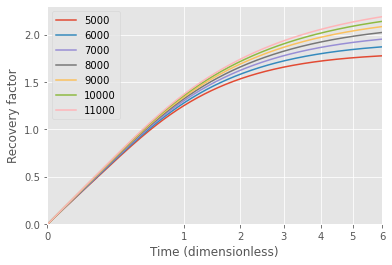

In [8]:
fig, ax = plt.subplots()
for k in reservoirs:
    ax.plot(time, reservoirs[k].recovery_factor(), label=k)
ax.set(xscale='squareroot', ylim=(0, None), xlim=(0, max(time)), xlabel="Time (dimensionless)", ylabel="Recovery factor")
ax.legend()

In [10]:
flow_properties = FlowProperties(fluid_properties, fvf_scale=1)

res_realgas = SinglePhaseReservoir(50, 1000, 12000, flow_properties)

%time res_realgas.simulate(time)
rf2 = res_realgas.recovery_factor()

CPU times: user 5.61 s, sys: 11.9 ms, total: 5.62 s
Wall time: 5.62 s


In [6]:
z = pvt_gas[pvt_gas['P'].isin([1000, 12000])]
print(z[['P', 'Bg', "Density"]])
1 - z.Density.iloc[0] / z.Density.iloc[1], 1 - z.Bg.iloc[1] / z.Bg.iloc[0]

          P        Bg    Density
100    1000  0.004183   2.112034
1200  12000  0.000542  16.289804


(0.8703462811111979, 0.870346281111212)

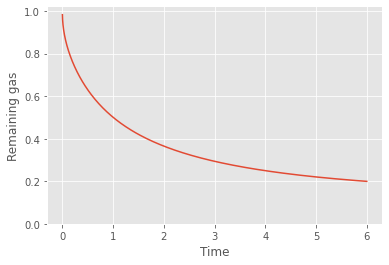

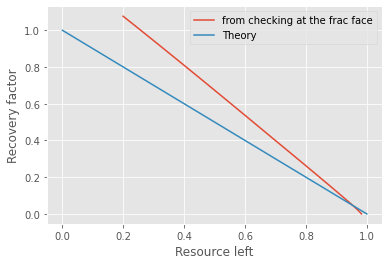

In [67]:
from scipy import interpolate
density_interp = interpolate.interp1d(fluid_properties["pseudopressure"], fluid_properties["density"])
def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt["pseudopressure"], pvt["density"])
    return (density(pseudopressure)).sum(axis=1)
remaining_gas = resource_left(res_realgas.pseudopressure, fluid_properties) / res_realgas.nx
#resource_left = res_realgas.pseudopressure * .sum(axis=1)/res_realgas.nx
fig, ax = plt.subplots()
ax.plot(time,remaining_gas)
ax.set(xlabel="Time", ylabel="Remaining gas", ylim=(0,None))

fig, ax = plt.subplots()
ax.plot(remaining_gas, rf2 * 0.565 * (1-density_interp(0)), label="from checking at the frac face")
ax.plot([1,0], [0,1], label="Theory")
ax.set(xlabel="Resource left", ylabel="Recovery factor")
ax.legend()

[(0.0, 2.4080071300596986)]

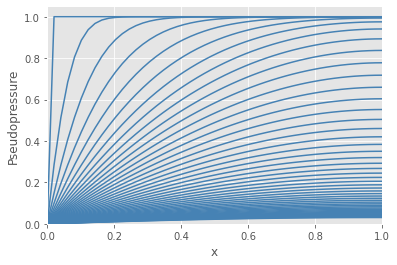

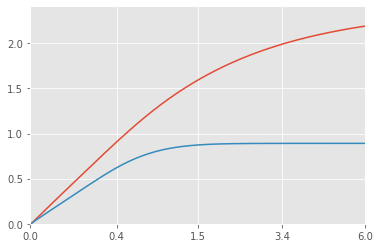

In [11]:
ax = plot_pseudopressure(res_realgas)

ax = plot_recovery_factor(res_realgas)
plot_recovery_factor(res_ideal, ax=ax)
ax.set(ylim=(0, max(res_realgas.recovery_factor())*1.1))

# Multiphase flow

In [ ]:
rel_perm_params = RelPermParams(n_o=2, n_g=2, n_w=2, S_or=0.2, S_wc=0.1, S_gc=0, k_ro_max=0.8, k_rw_max=0, k_rg_max=1)

In [ ]:
initial_saturations = {"So": 0.5, "Sg": 0.2, "Sw": 0.3}
sum(v for v in initial_saturations.values())